# Goal
- Filter for data around focus regions (Reservoirs.shp)
- Plot each focus point's level differences

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Config
reservoir_fpath_shapefile = './res/Reservoirs.shp'
swot_points_fpath_geojson = './res/water_mask_20250110140604.geojson'
save_fpath_geojson = './res/swot_points_reservoirs.geojson'

save_file = False


In [3]:
# Load data
reservoir = gpd.read_file(reservoir_fpath_shapefile)
swot_points = gpd.read_file(swot_points_fpath_geojson)

# Reproject to metric CRS
reservoir = reservoir.to_crs(epsg=3857)
swot_points = swot_points.to_crs(epsg=3857)

# Draw a buffer of 200m around reservoirs
reservoir_buffer = reservoir.buffer(200)
reservoir_buffer = gpd.GeoDataFrame(geometry=reservoir_buffer)

# Keep only the swot points that are within the buffer
swot_points_in_buffer = gpd.sjoin(swot_points, reservoir_buffer, predicate='within')

# Save the result
if save_file == True:
    swot_points_in_buffer.to_file(save_fpath_geojson, driver='GeoJSON')

# Make sure everything worked
if swot_points_in_buffer.shape[0] == 0:
    print('No SWOT points found within reservoirs')

/home/ben/miniconda3/envs/geo/lib/python3.12/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/home/ben/miniconda3/envs/geo/lib/python3.12/site-packages/geopandas/io/file.py:403: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore", utc=True)


# Inspect data using Matplotlib
Now that we have the data for each reservoir, we can use the index_right column to average the level differences for each reservoir.

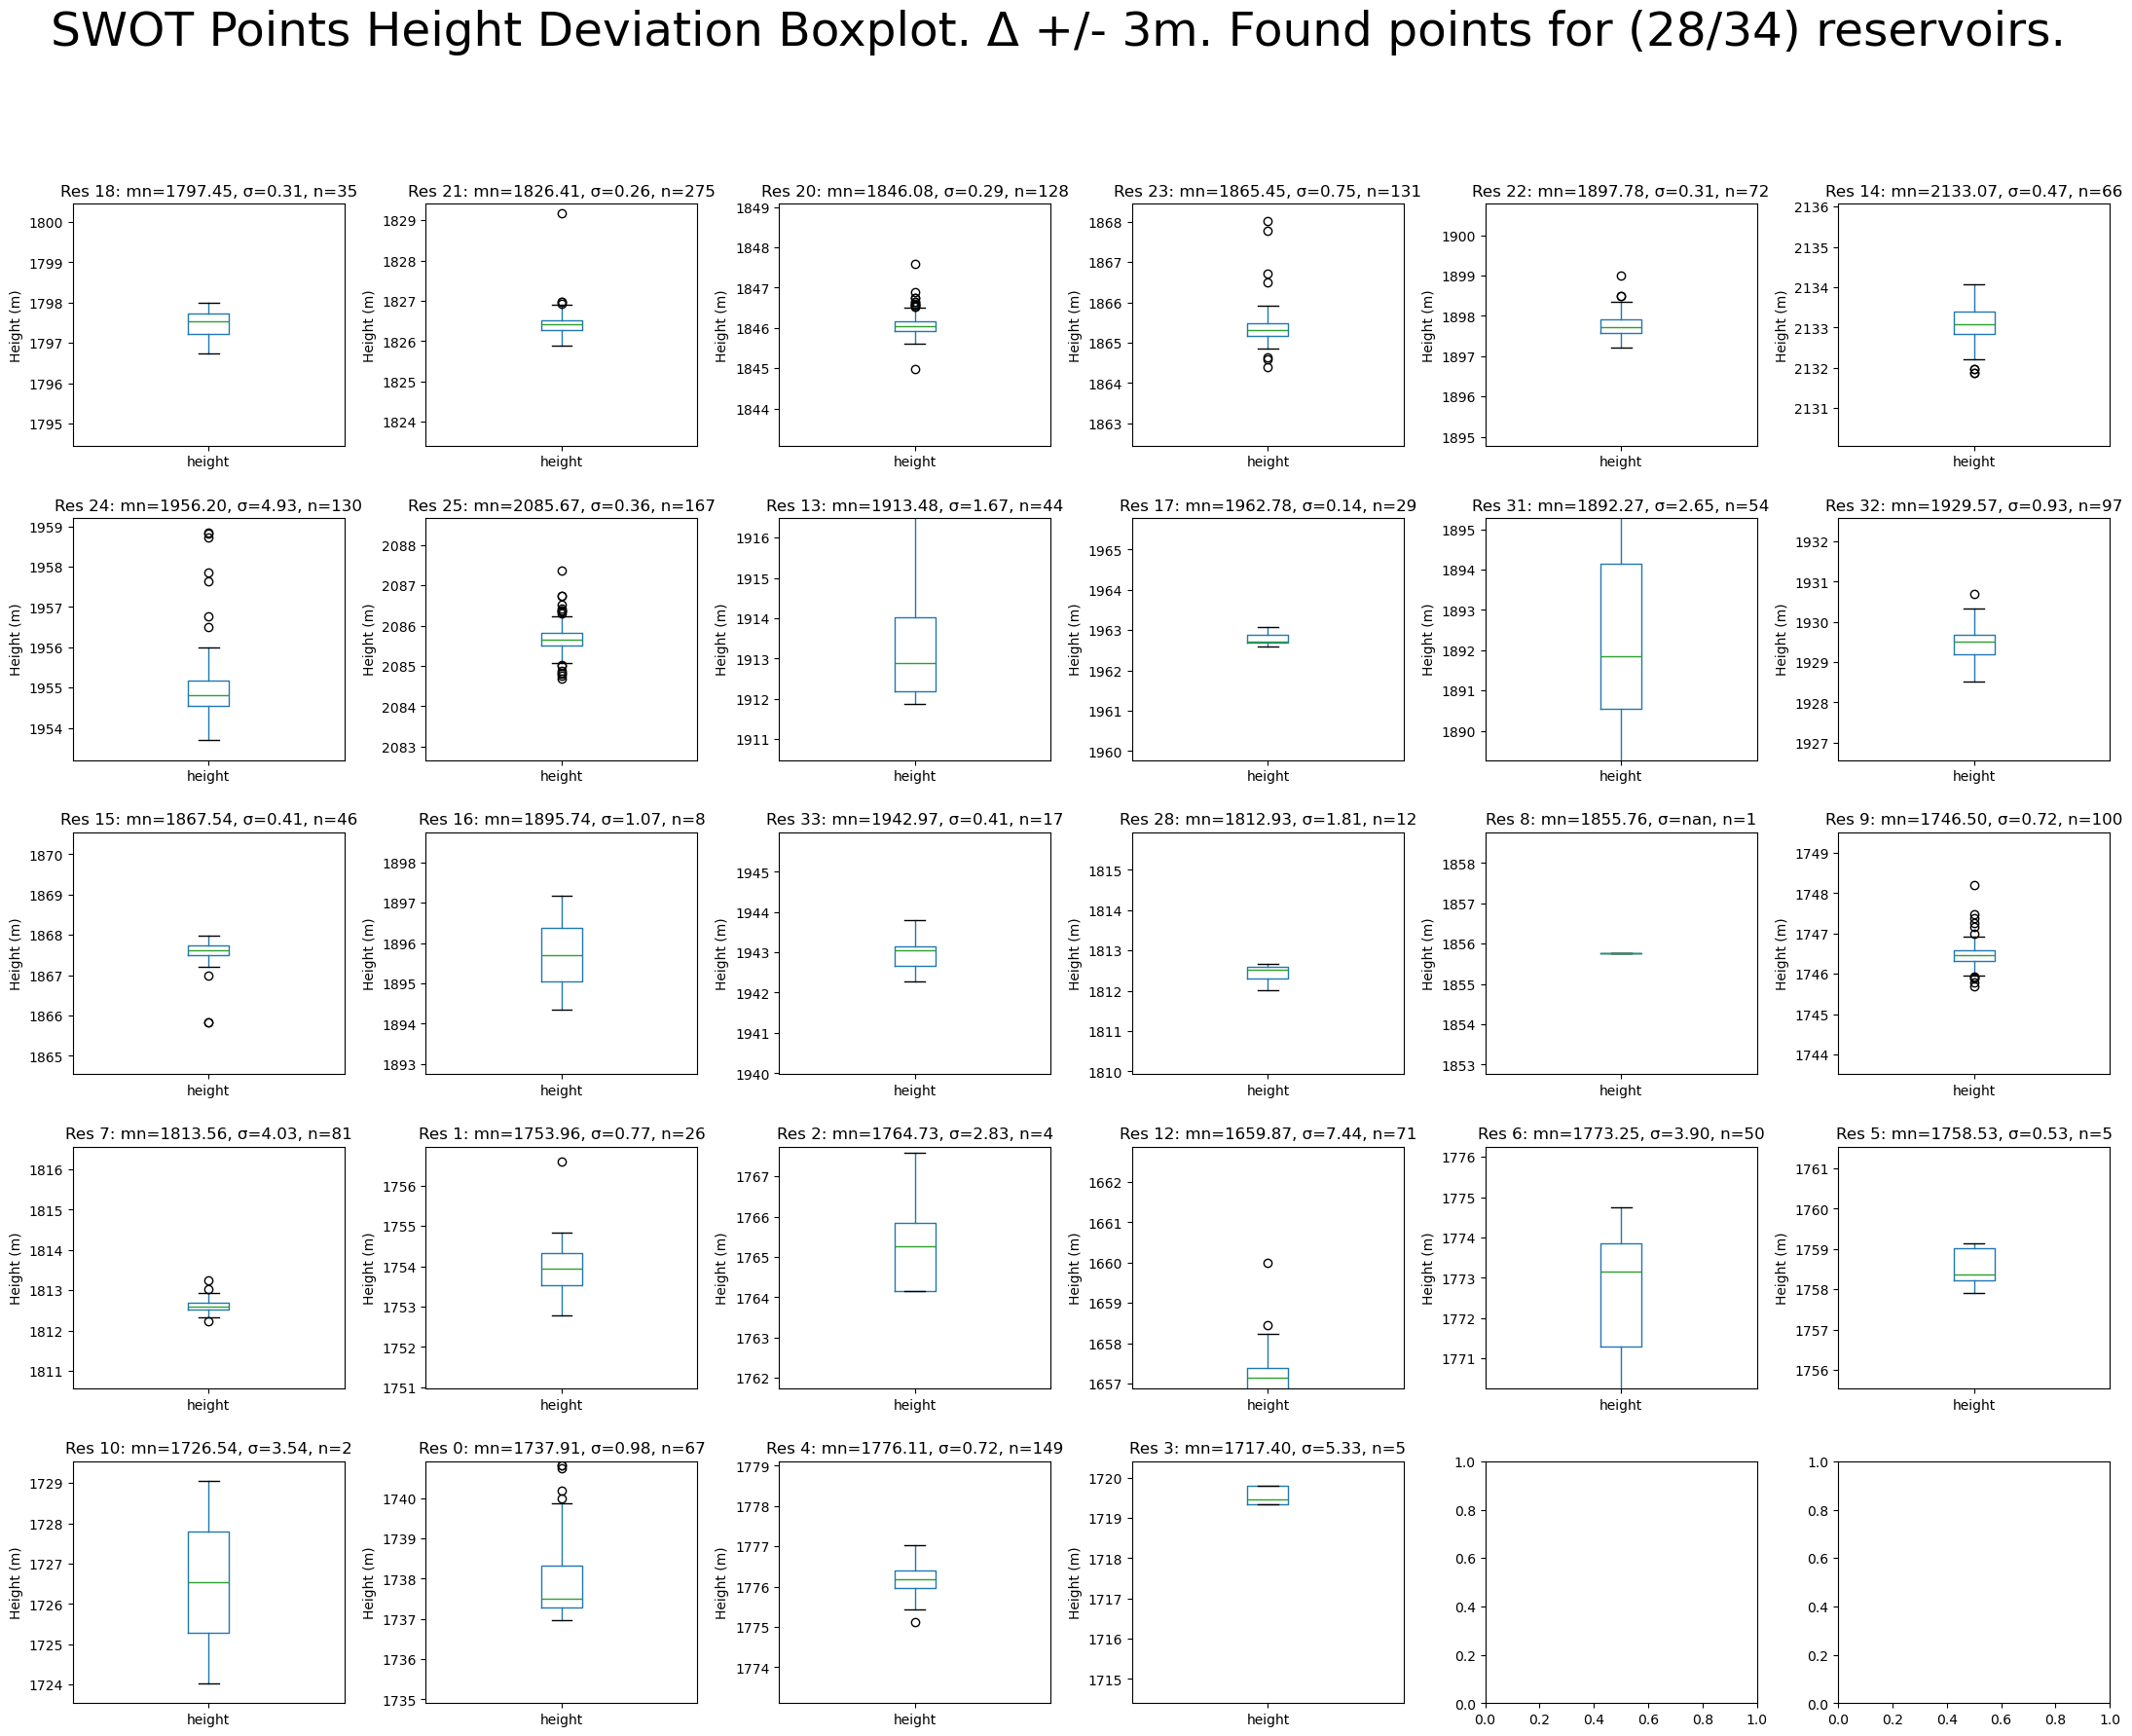

In [7]:
# Get unique reservoirs
reservoirs = swot_points_in_buffer['index_right'].unique()

# Only keep classification 3 and 4
swot_points_in_buffer = swot_points_in_buffer[swot_points_in_buffer['classification'].isin([3, 4])]

# Create subplots with 6 subplots per row
nrows = len(reservoirs) // 6 + 1
fig, axes = plt.subplots(nrows=nrows, ncols=6, figsize=(27, nrows * 4))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Count the number of reservoirs with data
n_reservoirs_with_data = 0

# Plot each reservoir
for ax, reservoir_id in zip(axes, reservoirs):
    try:
        # Filter data for the current reservoir
        reservoir_data = swot_points_in_buffer[swot_points_in_buffer['index_right'] == reservoir_id]
        
        # Calculate mean and standard deviation of height
        mean_height = reservoir_data['height'].mean()
        std_height = reservoir_data['height'].std()

        # Plot boxplot
        reservoir_data.boxplot(column='height', ax=ax, grid=False)

        # Set axis limits
        ax.set_ylim(mean_height - 3, mean_height + 3)

        # Increment counter
        n_reservoirs_with_data += 1

        # Set labels and title
        #ax.set_xlabel('Reservoir')
        ax.set_ylabel('Height (m)')
        ax.set_title(f'Res {reservoir_id}: mn={mean_height:.2f}, σ={std_height:.2f}, n={len(reservoir_data)}')
        fig.subplots_adjust(hspace=0.3, wspace=0.3)
    except:
        print(f"Error plotting reservoir {reservoir_id}. Likely no data available.")
        pass

# Set the title
fig.suptitle(f'SWOT Points Height Deviation Boxplot. Δ +/- 3m. Found points for ({n_reservoirs_with_data}/{len(reservoir.index)}) reservoirs.', fontsize=35)

# save the plot
plt.savefig('./res/swot_points_reservoirs_deviation_boxplot.png', dpi=150)


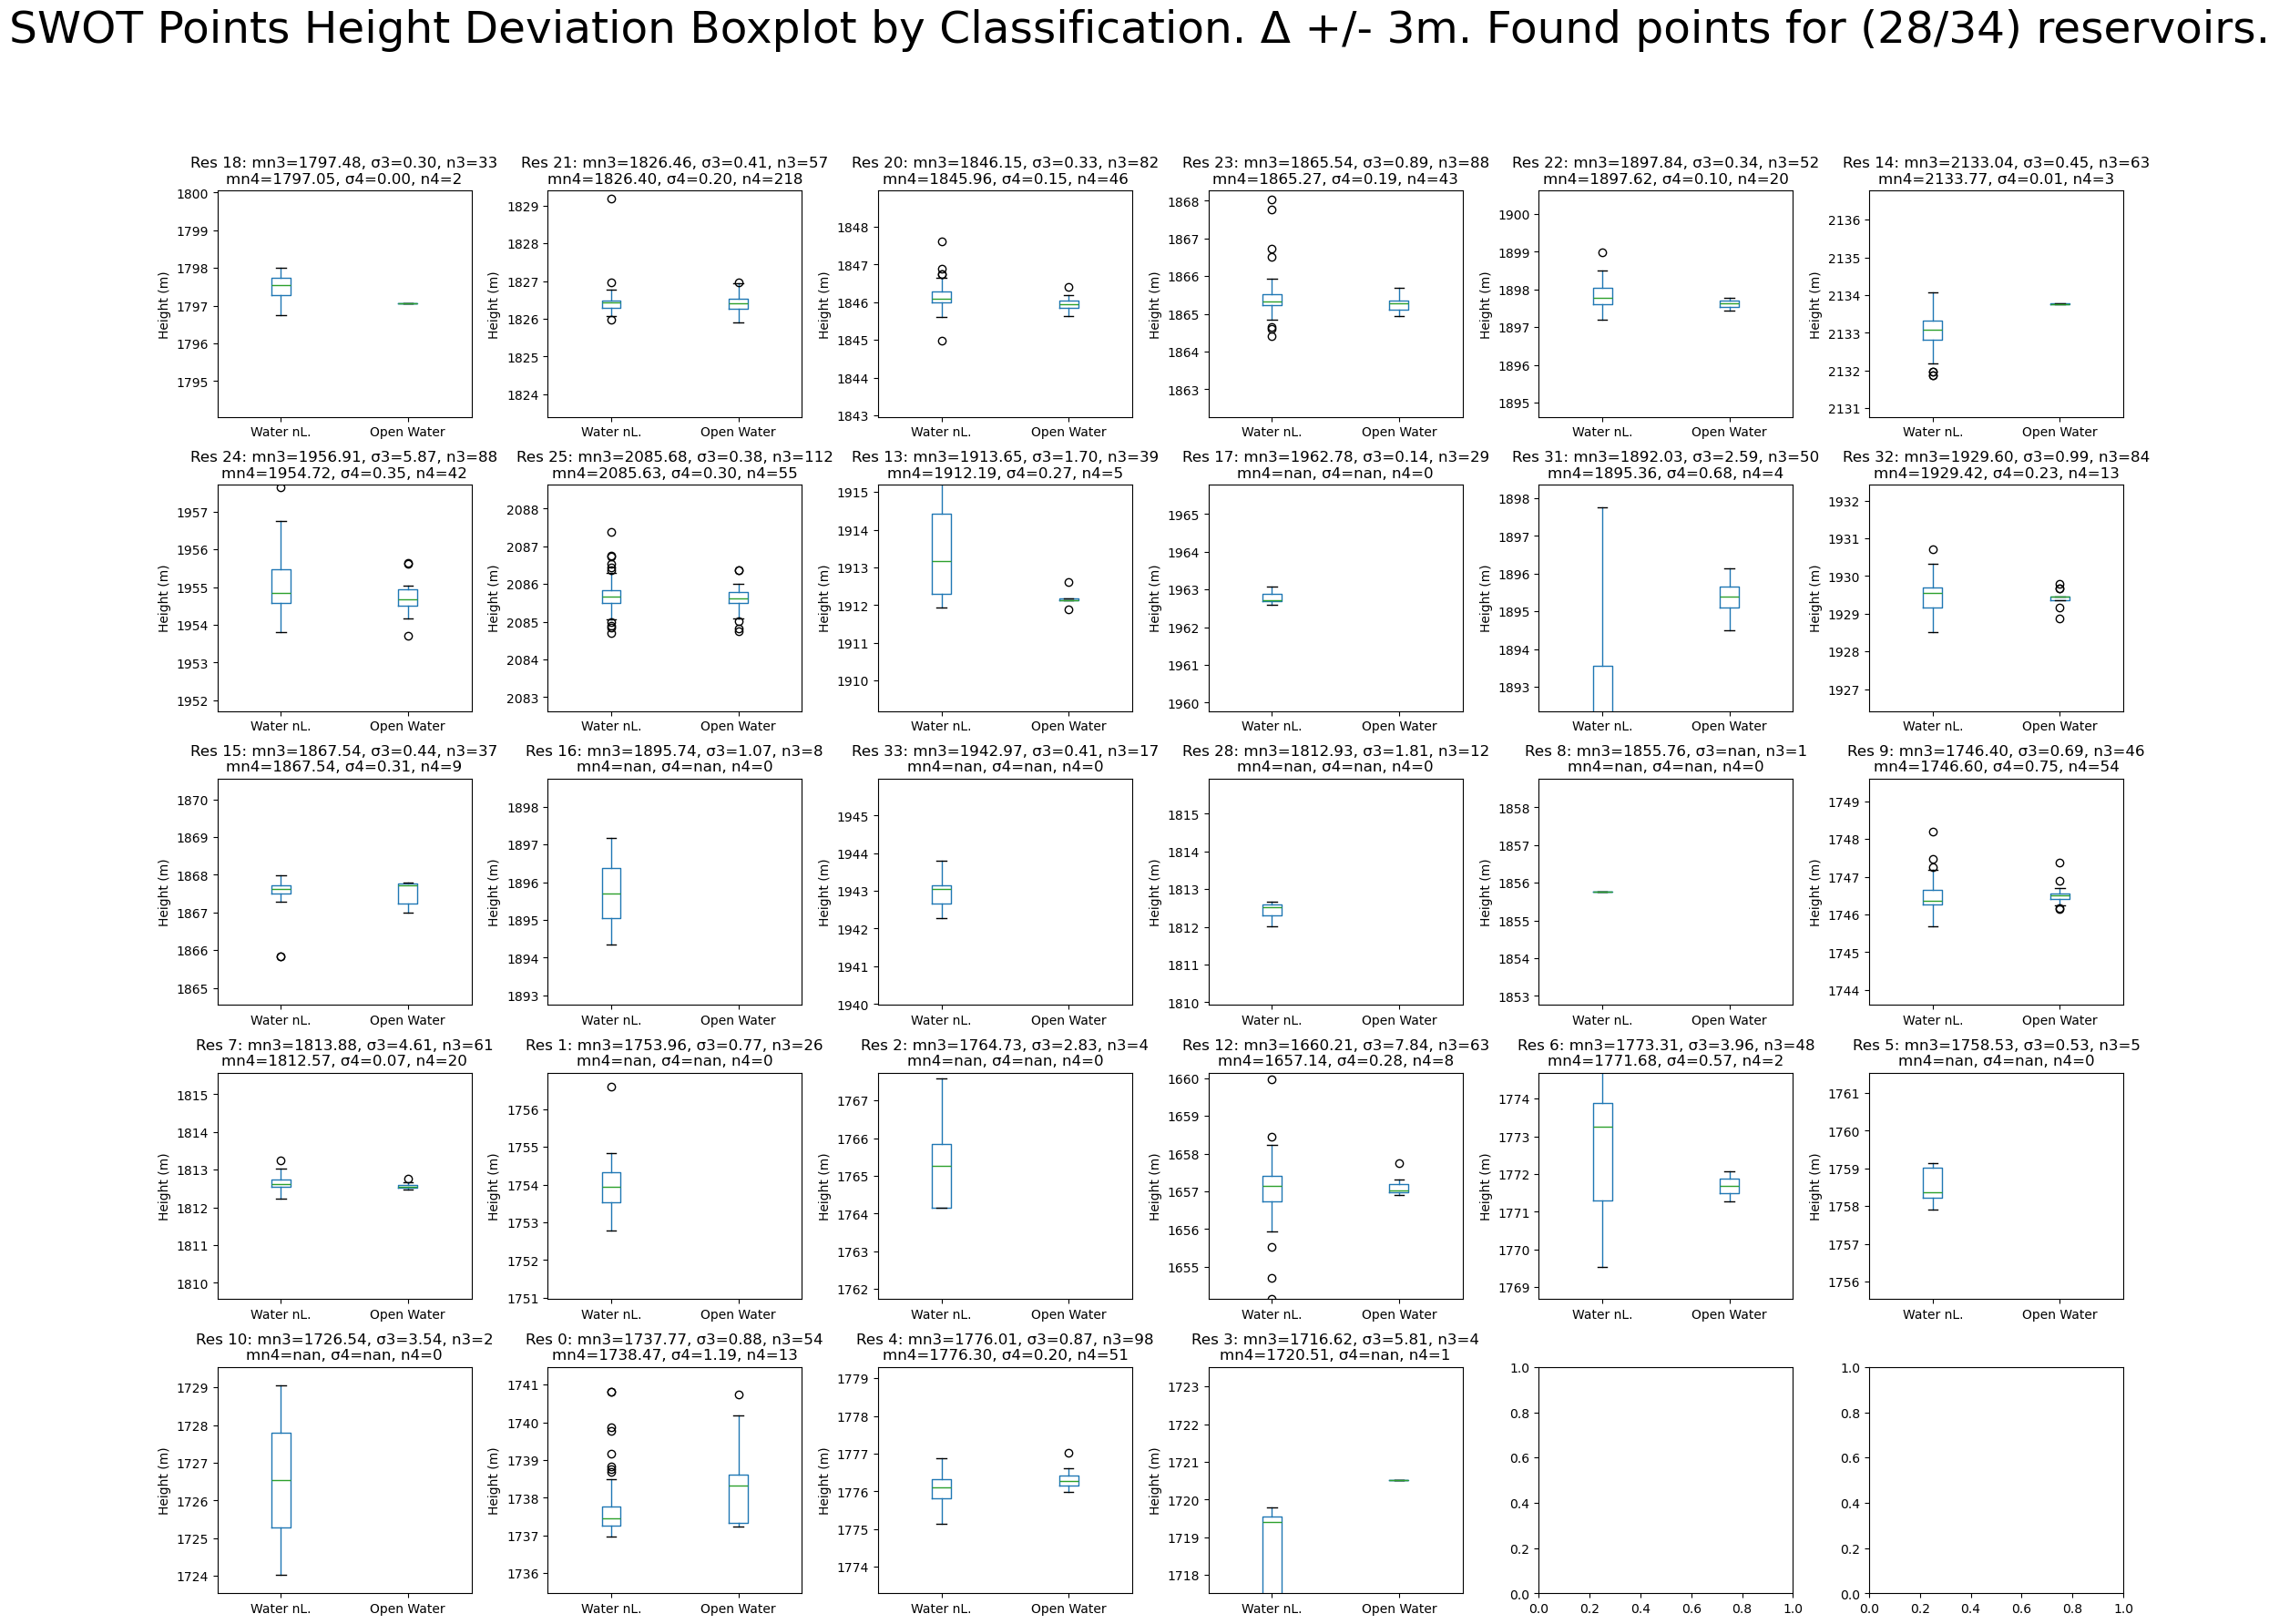

In [10]:
# Get unique reservoirs
reservoirs = swot_points_in_buffer['index_right'].unique()

# Create subplots with 6 subplots per row
nrows = len(reservoirs) // 6 + 1
fig, axes = plt.subplots(nrows=nrows, ncols=6, figsize=(27, nrows * 4))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Count the number of reservoirs with data
n_reservoirs_with_data = 0

# Plot each reservoir
for ax, reservoir_id in zip(axes, reservoirs):
    try:
        # Filter data for the current reservoir
        reservoir_data = swot_points_in_buffer[swot_points_in_buffer['index_right'] == reservoir_id]
        
        # Filter classification 3 and 4 separately
        class_3_data = reservoir_data[reservoir_data['classification'] == 3]
        class_4_data = reservoir_data[reservoir_data['classification'] == 4]
        
        # Calculate mean and standard deviation of height for classification 3
        mean_height_3 = class_3_data['height'].mean()
        std_height_3 = class_3_data['height'].std()
        
        # Calculate mean and standard deviation of height for classification 4
        mean_height_4 = class_4_data['height'].mean()
        std_height_4 = class_4_data['height'].std()
        
        # Plot boxplot for classification 3
        class_3_data.boxplot(column='height', ax=ax, grid=False, positions=[1])
        
        # Plot boxplot for classification 4
        class_4_data.boxplot(column='height', ax=ax, grid=False, positions=[2])
        
        # Calculate mean height for both classifications combined
        if not class_4_data.empty:
            mean_height_combined = mean_height_4
        else:
            mean_height_combined = mean_height_3
        
        # Set axis limits
        ax.set_ylim(mean_height_combined - 3, mean_height_combined + 3)
        
        # Increment counter
        n_reservoirs_with_data += 1
        
        # Set labels and title
        ax.set_ylabel('Height (m)')
        ax.set_title(f'Res {reservoir_id}: mn3={mean_height_3:.2f}, σ3={std_height_3:.2f}, n3={len(class_3_data)}\n'
                     f'mn4={mean_height_4:.2f}, σ4={std_height_4:.2f}, n4={len(class_4_data)}')
        ax.set_xticks([1, 2])
        ax.set_xticklabels(['Water nL.', 'Open Water'])
        fig.subplots_adjust(hspace=0.3, wspace=0.3)
    except Exception as e:
        print(f"Error plotting reservoir {reservoir_id}. Likely no data available. Error: {e}")
        pass

# Set the title
fig.suptitle(f'SWOT Points Height Deviation Boxplot by Classification. Δ +/- 3m. Found points for ({n_reservoirs_with_data}/{len(reservoir.index)}) reservoirs.', fontsize=35)

# Save the plot
plt.savefig('./res/swot_points_reservoirs_classification_deviation_2class_boxplot.png', dpi=150)


ModuleNotFoundError: No module named 'seaborn'